In [1]:
# 필요한 라이브러리 설치
%pip install autogluon pandas numpy matplotlib seaborn scikit-learn lightgbm xgboost


Note: you may need to restart the kernel to use updated packages.


In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# AutoGluon import
from autogluon.tabular import TabularDataset, TabularPredictor

# 추가 모델링 라이브러리
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료")


✅ 라이브러리 로드 완료


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 로드
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print("📊 데이터 로드 완료")
print(f"Train 데이터 크기: {train_df.shape}")
print(f"Test 데이터 크기: {test_df.shape}")
print(f"Building info 크기: {building_info.shape}")

# 원본 전력 소비량 분포 확인
original_power = train_df['전력소비량(kWh)']
print(f"\n🔍 원본 전력 소비량 통계:")
print(f"   평균: {original_power.mean():.2f} kWh")
print(f"   중앙값: {original_power.median():.2f} kWh")
print(f"   최댓값: {original_power.max():.2f} kWh")
print(f"   최솟값: {original_power.min():.2f} kWh")
print(f"   표준편차: {original_power.std():.2f} kWh")
print(f"   왜도(skewness): {original_power.skew():.3f}")


📊 데이터 로드 완료
Train 데이터 크기: (204000, 10)
Test 데이터 크기: (16800, 7)
Building info 크기: (100, 7)

🔍 원본 전력 소비량 통계:
   평균: 3329.58 kWh
   중앙값: 1935.72 kWh
   최댓값: 27155.94 kWh
   최솟값: 0.00 kWh
   표준편차: 3689.10 kWh
   왜도(skewness): 2.321


In [4]:
# 로그 변환 함수 정의
def log_transform_power(power_data):
    """
    전력 소비량을 자연로그로 변환하는 함수
    
    Parameters:
    - power_data: 전력소비량 데이터 (Series 또는 array)
    
    Returns:
    - 로그 변환된 전력소비량 데이터
    """
    return np.log(power_data + 1)  # +1로 0값 처리

def inverse_log_transform(log_power_data):
    """
    로그 변환된 데이터를 원래 단위로 복원하는 함수
    
    Parameters:
    - log_power_data: 로그 변환된 전력소비량 데이터
    
    Returns:
    - 원래 단위의 전력소비량 데이터
    """
    return np.exp(log_power_data) - 1

# 로그 변환 적용
train_df['log_power'] = log_transform_power(train_df['전력소비량(kWh)'])

# 로그 변환 후 분포 확인
log_power = train_df['log_power']
print(f"\n🔍 로그 변환 후 전력 소비량 통계:")
print(f"   평균: {log_power.mean():.3f} log(kWh)")
print(f"   중앙값: {log_power.median():.3f} log(kWh)")
print(f"   최댓값: {log_power.max():.3f} log(kWh)")
print(f"   최솟값: {log_power.min():.3f} log(kWh)")
print(f"   표준편차: {log_power.std():.3f} log(kWh)")
print(f"   왜도(skewness): {log_power.skew():.3f}")

print(f"\n✅ 로그 변환 완료 - 왜도 개선: {original_power.skew():.3f} → {log_power.skew():.3f}")



🔍 로그 변환 후 전력 소비량 통계:
   평균: 7.619 log(kWh)
   중앙값: 7.569 log(kWh)
   최댓값: 10.209 log(kWh)
   최솟값: 0.000 log(kWh)
   표준편차: 1.078 log(kWh)
   왜도(skewness): -0.980

✅ 로그 변환 완료 - 왜도 개선: 2.321 → -0.980


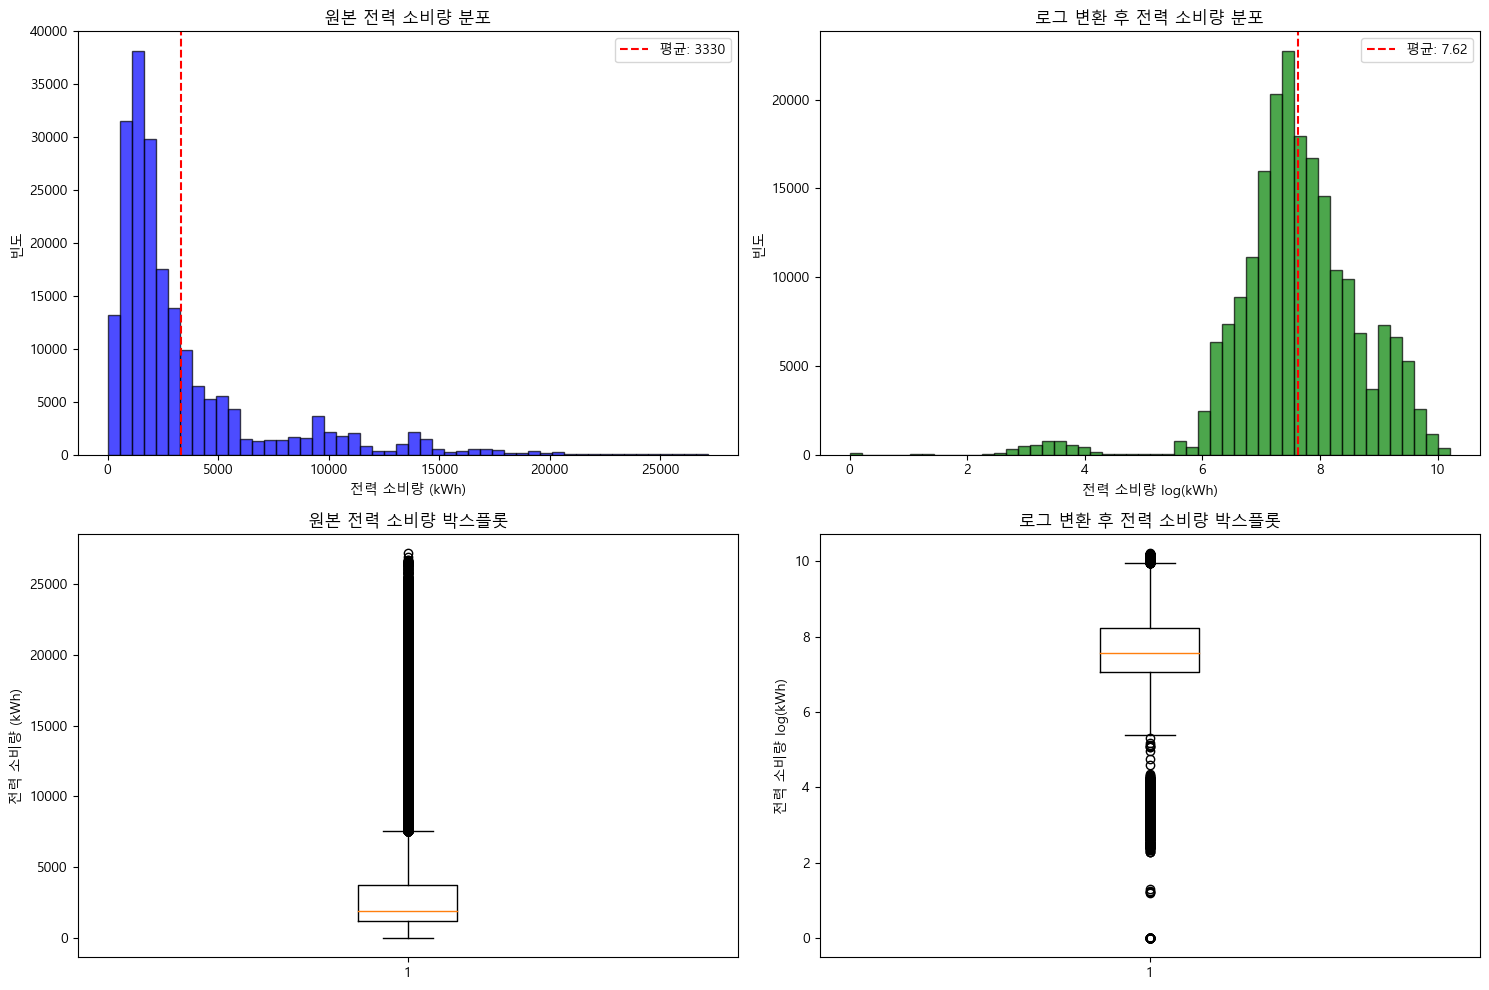

📊 로그 변환을 통해 치우친 분포가 정규분포에 가까워졌습니다!


In [5]:
# 로그 변환 효과 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 원본 데이터 히스토그램
axes[0, 0].hist(original_power, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('원본 전력 소비량 분포')
axes[0, 0].set_xlabel('전력 소비량 (kWh)')
axes[0, 0].set_ylabel('빈도')
axes[0, 0].axvline(original_power.mean(), color='red', linestyle='--', 
                   label=f'평균: {original_power.mean():.0f}')
axes[0, 0].legend()

# 로그 변환 데이터 히스토그램
axes[0, 1].hist(log_power, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('로그 변환 후 전력 소비량 분포')
axes[0, 1].set_xlabel('전력 소비량 log(kWh)')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].axvline(log_power.mean(), color='red', linestyle='--', 
                   label=f'평균: {log_power.mean():.2f}')
axes[0, 1].legend()

# 원본 데이터 박스플롯
axes[1, 0].boxplot(original_power)
axes[1, 0].set_title('원본 전력 소비량 박스플롯')
axes[1, 0].set_ylabel('전력 소비량 (kWh)')

# 로그 변환 데이터 박스플롯
axes[1, 1].boxplot(log_power)
axes[1, 1].set_title('로그 변환 후 전력 소비량 박스플롯')
axes[1, 1].set_ylabel('전력 소비량 log(kWh)')

plt.tight_layout()
plt.show()

print("📊 로그 변환을 통해 치우친 분포가 정규분포에 가까워졌습니다!")


In [6]:
def create_features(df, building_info):
    """
    Feature Engineering 함수 - 기존 baseline과 동일한 피처 생성
    """
    # 데이터 복사
    df = df.copy()
    
    # 건물 정보에서 불필요한 컬럼 제거
    building_info_processed = building_info.copy()
    
    # 사용하지 않을 컬럼들 제거
    drop_columns = ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
    for col in drop_columns:
        if col in building_info_processed.columns:
            building_info_processed = building_info_processed.drop(col, axis=1)
    
    # 건물 정보 병합
    df = df.merge(building_info_processed, on='건물번호', how='left')
    
    # 원본 데이터에서 불필요한 컬럼 제거
    drop_original_columns = ['일조(hr)', '일사(MJ/m2)']
    for col in drop_original_columns:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    # 날짜/시간 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 관련 피처
    df['연도'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['일'] = df['일시'].dt.day
    df['시간'] = df['일시'].dt.hour
    df['요일'] = df['일시'].dt.dayofweek
    df['주말여부'] = (df['요일'] >= 5).astype(int)
    
    # 계절 피처
    df['계절'] = df['월'].apply(lambda x: 0 if x in [12, 1, 2] else 
                              1 if x in [3, 4, 5] else 
                              2 if x in [6, 7, 8] else 3)
    
    # 시간대 구분
    df['시간대'] = df['시간'].apply(lambda x: 0 if 6 <= x < 12 else 
                                1 if 12 <= x < 18 else 
                                2 if 18 <= x < 24 else 3)
    
    # 온도 관련 피처
    df['온도_제곱'] = df['기온(°C)'] ** 2
    
    # CDH (Cooling Degree Hours) - 냉방도시
    df['CDH'] = np.maximum(df['기온(°C)'] - 26, 0)
    
    # THI (Temperature Humidity Index) - 온습도지수
    df['THI'] = 9/5 * df['기온(°C)'] - 0.55 * (1 - df['습도(%)'] / 100) * (9/5 * df['기온(°C)'] - 26) + 32
    
    # 기상 상호작용
    df['습도_온도'] = df['습도(%)'] * df['기온(°C)']
    df['바람세기'] = df['풍속(m/s)'] * df['기온(°C)']
    
    # 건물 관련 피처
    df['냉방면적_비율'] = df['냉방면적(m2)'] / (df['연면적(m2)'] + 1)
    
    return df

# Feature Engineering 적용
train_processed = create_features(train_df, building_info)
test_processed = create_features(test_df, building_info)

print("✅ Feature Engineering 완료")
print(f"처리된 train 데이터 크기: {train_processed.shape}")
print(f"처리된 test 데이터 크기: {test_processed.shape}")


✅ Feature Engineering 완료
처리된 train 데이터 크기: (204000, 26)
처리된 test 데이터 크기: (16800, 24)


In [8]:
train_processed.head(5)

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),log_power,건물유형,...,요일,주말여부,계절,시간대,온도_제곱,CDH,THI,습도_온도,바람세기,냉방면적_비율
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,5794.80,8.664889,호텔,...,5,1,2,3,334.89,0.0,64.25294,1500.6,47.58,0.935744
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,5591.85,8.629244,호텔,...,5,1,2,3,334.89,0.0,64.25294,1500.6,49.41,0.935744
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,5338.17,8.582825,호텔,...,5,1,2,3,327.61,0.0,63.85620,1448.0,47.06,0.935744
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,4554.42,8.424073,호텔,...,5,1,2,3,324.00,0.0,63.73120,1458.0,46.80,0.935744
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,3602.25,8.189591,호텔,...,5,1,2,3,316.84,0.0,63.40882,1441.8,23.14,0.935744


🔍 가중치 분포 분석:
   Power 방법 - 평균: 1.000, 범위: 0.667 ~ 3.385
   Quantile 방법 - 평균: 1.000, 범위: 0.800 ~ 1.200
   Sqrt 방법 - 평균: 1.000, 범위: 0.692 ~ 1.680


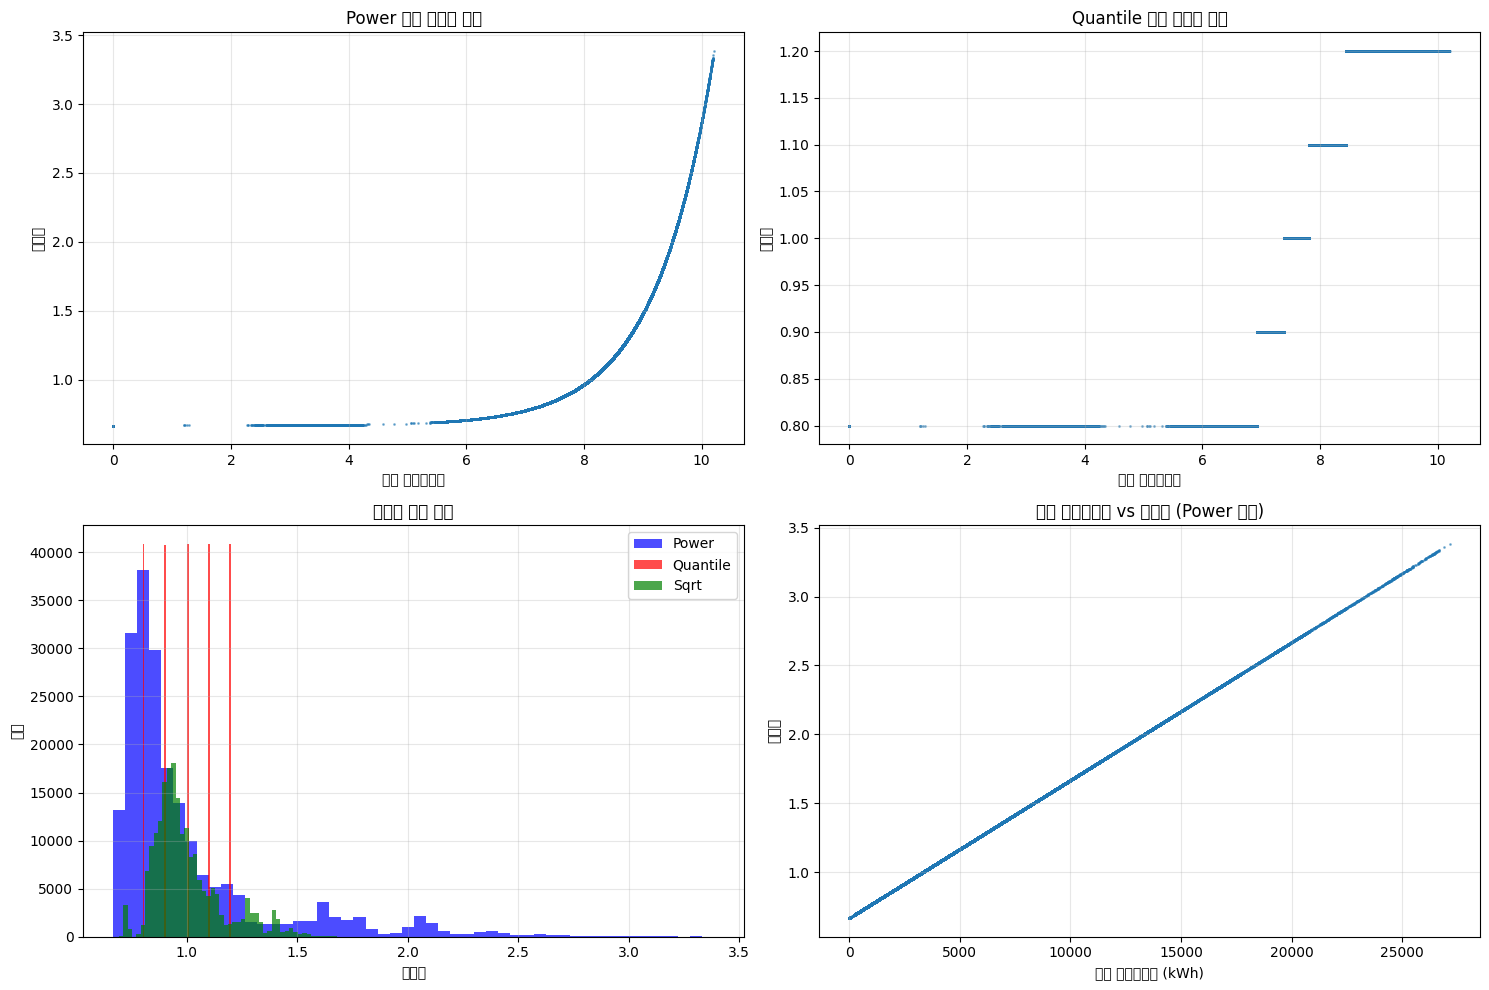

✅ 가중치 계산 완료 - 높은 전력소비량에 더 큰 가중치 부여


In [7]:
# Weighted MSE를 위한 가중치 계산
def calculate_weights(y_true, method='power', alpha=0.5):
    """
    Weighted MSE를 위한 가중치 계산
    
    Parameters:
    - y_true: 실제값 (로그 변환된 전력소비량)
    - method: 가중치 계산 방법
        - 'power': 전력소비량 크기에 비례
        - 'quantile': 분위수 기반
        - 'sqrt': 제곱근 기반
    - alpha: 가중치 강도 조절 파라미터
    
    Returns:
    - weights: 각 샘플의 가중치
    """
    
    if method == 'power':
        # 로그 변환된 값을 원래 단위로 복원하여 가중치 계산
        original_values = inverse_log_transform(y_true)
        # 높은 전력소비량에 더 큰 가중치 부여
        weights = 1 + alpha * (original_values / original_values.mean())
        
    elif method == 'quantile':
        # 분위수 기반 가중치
        quantiles = pd.qcut(y_true, q=5, labels=False)  # 5분위로 나눔
        weights = 1 + alpha * (quantiles / 4)  # 상위 분위수일수록 큰 가중치
        
    elif method == 'sqrt':
        # 제곱근 기반 가중치 (완만한 증가)
        original_values = inverse_log_transform(y_true)
        weights = 1 + alpha * np.sqrt(original_values / original_values.mean())
        
    else:
        weights = np.ones(len(y_true))  # 균등 가중치
    
    # 가중치 정규화
    weights = weights / weights.mean()
    
    return weights

# 가중치 계산 및 시각화
log_power_values = train_processed['log_power']
weights_power = calculate_weights(log_power_values, method='power', alpha=0.5)
weights_quantile = calculate_weights(log_power_values, method='quantile', alpha=0.5)
weights_sqrt = calculate_weights(log_power_values, method='sqrt', alpha=0.5)

print("🔍 가중치 분포 분석:")
print(f"   Power 방법 - 평균: {weights_power.mean():.3f}, 범위: {weights_power.min():.3f} ~ {weights_power.max():.3f}")
print(f"   Quantile 방법 - 평균: {weights_quantile.mean():.3f}, 범위: {weights_quantile.min():.3f} ~ {weights_quantile.max():.3f}")
print(f"   Sqrt 방법 - 평균: {weights_sqrt.mean():.3f}, 범위: {weights_sqrt.min():.3f} ~ {weights_sqrt.max():.3f}")

# 가중치 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 로그 전력소비량 vs 가중치 (Power 방법)
axes[0, 0].scatter(log_power_values, weights_power, alpha=0.5, s=1)
axes[0, 0].set_xlabel('로그 전력소비량')
axes[0, 0].set_ylabel('가중치')
axes[0, 0].set_title('Power 방법 가중치 분포')
axes[0, 0].grid(True, alpha=0.3)

# 로그 전력소비량 vs 가중치 (Quantile 방법)
axes[0, 1].scatter(log_power_values, weights_quantile, alpha=0.5, s=1)
axes[0, 1].set_xlabel('로그 전력소비량')
axes[0, 1].set_ylabel('가중치')
axes[0, 1].set_title('Quantile 방법 가중치 분포')
axes[0, 1].grid(True, alpha=0.3)

# 가중치 히스토그램 비교
axes[1, 0].hist(weights_power, bins=50, alpha=0.7, label='Power', color='blue')
axes[1, 0].hist(weights_quantile, bins=50, alpha=0.7, label='Quantile', color='red')
axes[1, 0].hist(weights_sqrt, bins=50, alpha=0.7, label='Sqrt', color='green')
axes[1, 0].set_xlabel('가중치')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].set_title('가중치 분포 비교')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 원본 전력소비량 vs 가중치 (Power 방법)
original_power_values = inverse_log_transform(log_power_values)
axes[1, 1].scatter(original_power_values, weights_power, alpha=0.5, s=1)
axes[1, 1].set_xlabel('원본 전력소비량 (kWh)')
axes[1, 1].set_ylabel('가중치')
axes[1, 1].set_title('원본 전력소비량 vs 가중치 (Power 방법)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 가중치 계산 완료 - 높은 전력소비량에 더 큰 가중치 부여")


In [8]:
# LightGBM을 위한 데이터 준비
exclude_columns = ['일시', '전력소비량(kWh)', 'log_power']
if 'num_date_time' in train_processed.columns:
    exclude_columns.append('num_date_time')

feature_columns = [col for col in train_processed.columns if col not in exclude_columns]

# 훈련 데이터 준비
X_train = train_processed[feature_columns].copy()
y_train_log = train_processed['log_power'].copy()

# 카테고리 변수 인코딩
categorical_features = ['건물유형']
label_encoders = {}

for cat_col in categorical_features:
    if cat_col in X_train.columns:
        le = LabelEncoder()
        X_train[cat_col] = le.fit_transform(X_train[cat_col].astype(str))
        label_encoders[cat_col] = le

# 결측치 처리
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train[numeric_columns] = X_train[numeric_columns].fillna(X_train[numeric_columns].mean())

# 훈련/검증 데이터 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_log, test_size=0.2, random_state=42
)

# 가중치 계산
weights_train = calculate_weights(y_train_split, method='power', alpha=0.5)
weights_val = calculate_weights(y_val_split, method='power', alpha=0.5)

print("=== LightGBM Weighted MSE 모델 훈련 준비 ===")
print(f"훈련 데이터 크기: {X_train_split.shape}")
print(f"검증 데이터 크기: {X_val_split.shape}")
print(f"피처 개수: {len(feature_columns)}")
print(f"가중치 범위: {weights_train.min():.3f} ~ {weights_train.max():.3f}")

# LightGBM 데이터셋 생성
train_dataset_lgb = lgb.Dataset(
    X_train_split, 
    label=y_train_split,
    weight=weights_train,
    categorical_feature=categorical_features if any(col in X_train_split.columns for col in categorical_features) else 'auto'
)

val_dataset_lgb = lgb.Dataset(
    X_val_split, 
    label=y_val_split,
    weight=weights_val,
    reference=train_dataset_lgb
)

# LightGBM 하이퍼파라미터 설정
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("\n=== LightGBM 훈련 시작 ===")
print("사용 설정:")
print("- 목표: 회귀 (로그 변환된 target)")
print("- 가중치: 높은 전력소비량에 더 큰 가중치")
print("- 평가 지표: RMSE")
print("- Early stopping: 100 rounds")

# LightGBM 모델 훈련
lgb_model = lgb.train(
    lgb_params,
    train_dataset_lgb,
    valid_sets=[train_dataset_lgb, val_dataset_lgb],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

print("\n✅ LightGBM Weighted MSE 모델 훈련 완료!")


=== LightGBM Weighted MSE 모델 훈련 준비 ===
훈련 데이터 크기: (163200, 22)
검증 데이터 크기: (40800, 22)
피처 개수: 22
가중치 범위: 0.667 ~ 3.384

=== LightGBM 훈련 시작 ===
사용 설정:
- 목표: 회귀 (로그 변환된 target)
- 가중치: 높은 전력소비량에 더 큰 가중치
- 평가 지표: RMSE
- Early stopping: 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.231386	valid's rmse: 0.226214
[200]	train's rmse: 0.190736	valid's rmse: 0.186296
[300]	train's rmse: 0.1726	valid's rmse: 0.169716
[400]	train's rmse: 0.161525	valid's rmse: 0.160945
[500]	train's rmse: 0.154062	valid's rmse: 0.154688
[600]	train's rmse: 0.146946	valid's rmse: 0.149113
[700]	train's rmse: 0.140847	valid's rmse: 0.144019
[800]	train's rmse: 0.13589	valid's rmse: 0.140316
[900]	train's rmse: 0.131427	valid's rmse: 0.137288
[1000]	train's rmse: 0.127664	valid's rmse: 0.134715
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.127664	valid's rmse: 0.134715

✅ LightGBM Weighted MSE 모델 훈련 완료!


=== LightGBM Weighted MSE 모델 성능 ===
RMSE (로그 변환): 0.1538
MAE (로그 변환): 0.0742

LightGBM 원본 스케일 성능:
RMSE (원본): 300.21 kWh
MAE (원본): 173.37 kWh


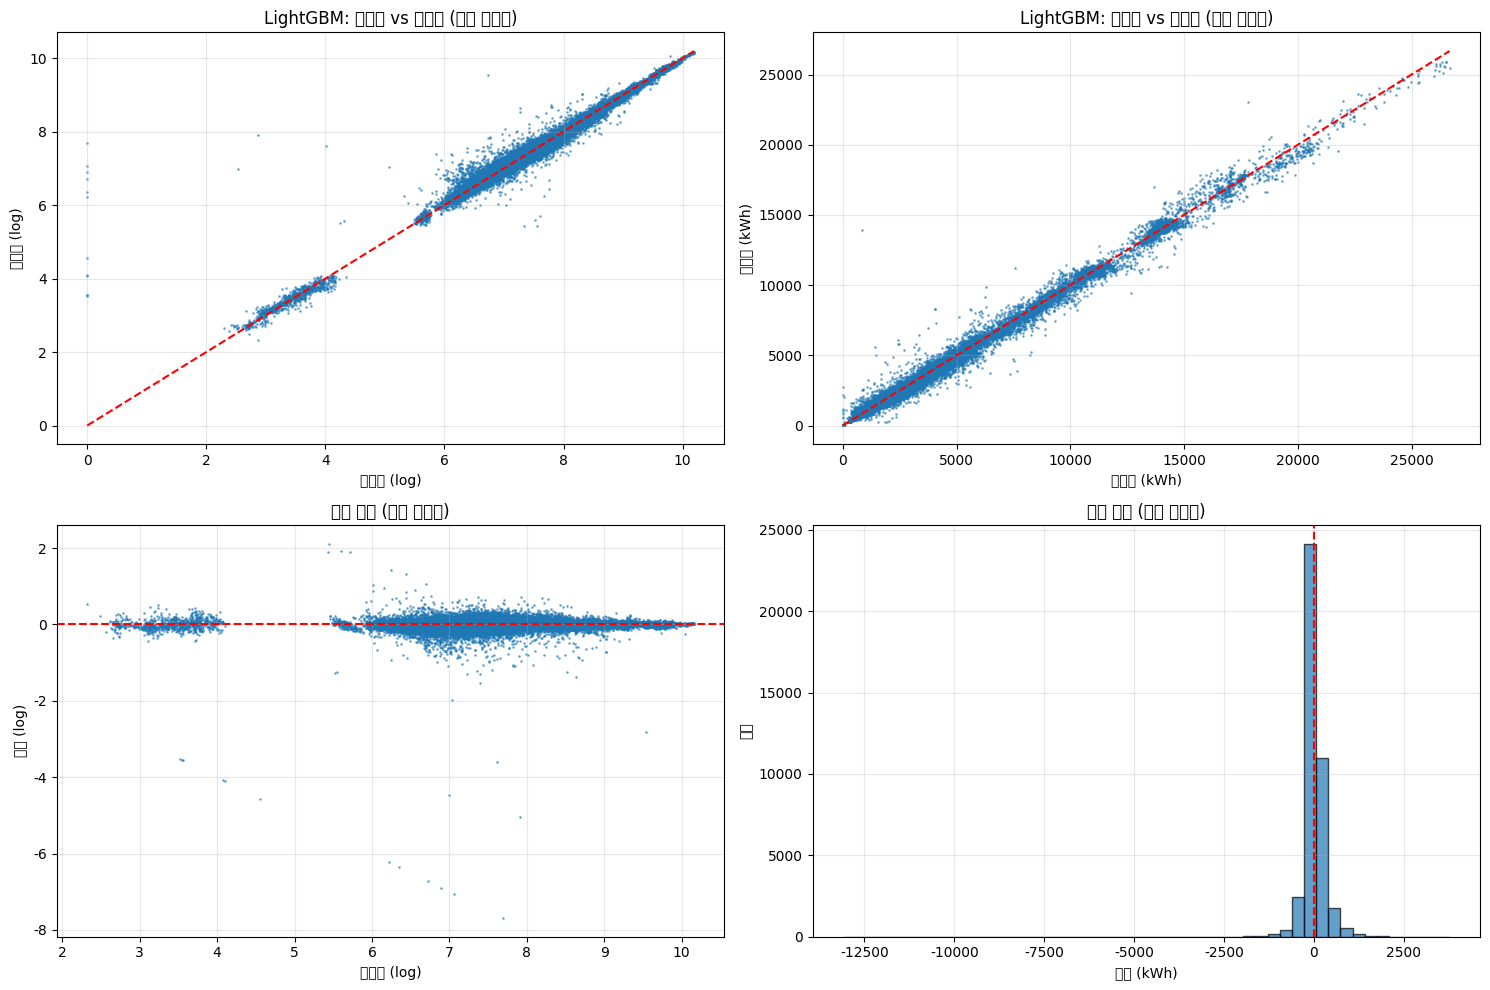

📊 성능 분석 완료!


In [9]:
# LightGBM 모델 검증 성능
lgb_pred_val = lgb_model.predict(X_val_split)
lgb_rmse = np.sqrt(mean_squared_error(y_val_split, lgb_pred_val))
lgb_mae = mean_absolute_error(y_val_split, lgb_pred_val)

print(f"=== LightGBM Weighted MSE 모델 성능 ===")
print(f"RMSE (로그 변환): {lgb_rmse:.4f}")
print(f"MAE (로그 변환): {lgb_mae:.4f}")

# 원본 스케일로 변환하여 성능 비교
y_val_original = inverse_log_transform(y_val_split)
lgb_pred_original = inverse_log_transform(lgb_pred_val)

lgb_rmse_original = np.sqrt(mean_squared_error(y_val_original, lgb_pred_original))
lgb_mae_original = mean_absolute_error(y_val_original, lgb_pred_original)

print(f"\nLightGBM 원본 스케일 성능:")
print(f"RMSE (원본): {lgb_rmse_original:.2f} kWh")
print(f"MAE (원본): {lgb_mae_original:.2f} kWh")

# 성능 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 실제값 vs 예측값 산점도 (로그 스케일)
axes[0, 0].scatter(y_val_split, lgb_pred_val, alpha=0.5, s=1)
axes[0, 0].plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], 'r--')
axes[0, 0].set_xlabel('실제값 (log)')
axes[0, 0].set_ylabel('예측값 (log)')
axes[0, 0].set_title('LightGBM: 실제값 vs 예측값 (로그 스케일)')
axes[0, 0].grid(True, alpha=0.3)

# 실제값 vs 예측값 산점도 (원본 스케일)
axes[0, 1].scatter(y_val_original, lgb_pred_original, alpha=0.5, s=1)
axes[0, 1].plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')
axes[0, 1].set_xlabel('실제값 (kWh)')
axes[0, 1].set_ylabel('예측값 (kWh)')
axes[0, 1].set_title('LightGBM: 실제값 vs 예측값 (원본 스케일)')
axes[0, 1].grid(True, alpha=0.3)

# 잔차 분석 (로그 스케일)
residuals_log = y_val_split - lgb_pred_val
axes[1, 0].scatter(lgb_pred_val, residuals_log, alpha=0.5, s=1)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('예측값 (log)')
axes[1, 0].set_ylabel('잔차 (log)')
axes[1, 0].set_title('잔차 분석 (로그 스케일)')
axes[1, 0].grid(True, alpha=0.3)

# 잔차 히스토그램 (원본 스케일)
residuals_original = y_val_original - lgb_pred_original
axes[1, 1].hist(residuals_original, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('잔차 (kWh)')
axes[1, 1].set_ylabel('빈도')
axes[1, 1].set_title('잔차 분포 (원본 스케일)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 성능 분석 완료!")


=== 테스트 데이터 전처리 ===
테스트 데이터 크기: (16800, 22)
결측치 없음 ✓
\n=== 예측 결과 ===
LightGBM 예측 (로그): 2.722 ~ 10.147
LightGBM 예측 (원본): 14.21 ~ 25509.21 kWh
LightGBM 예측 평균: 3540.52 kWh


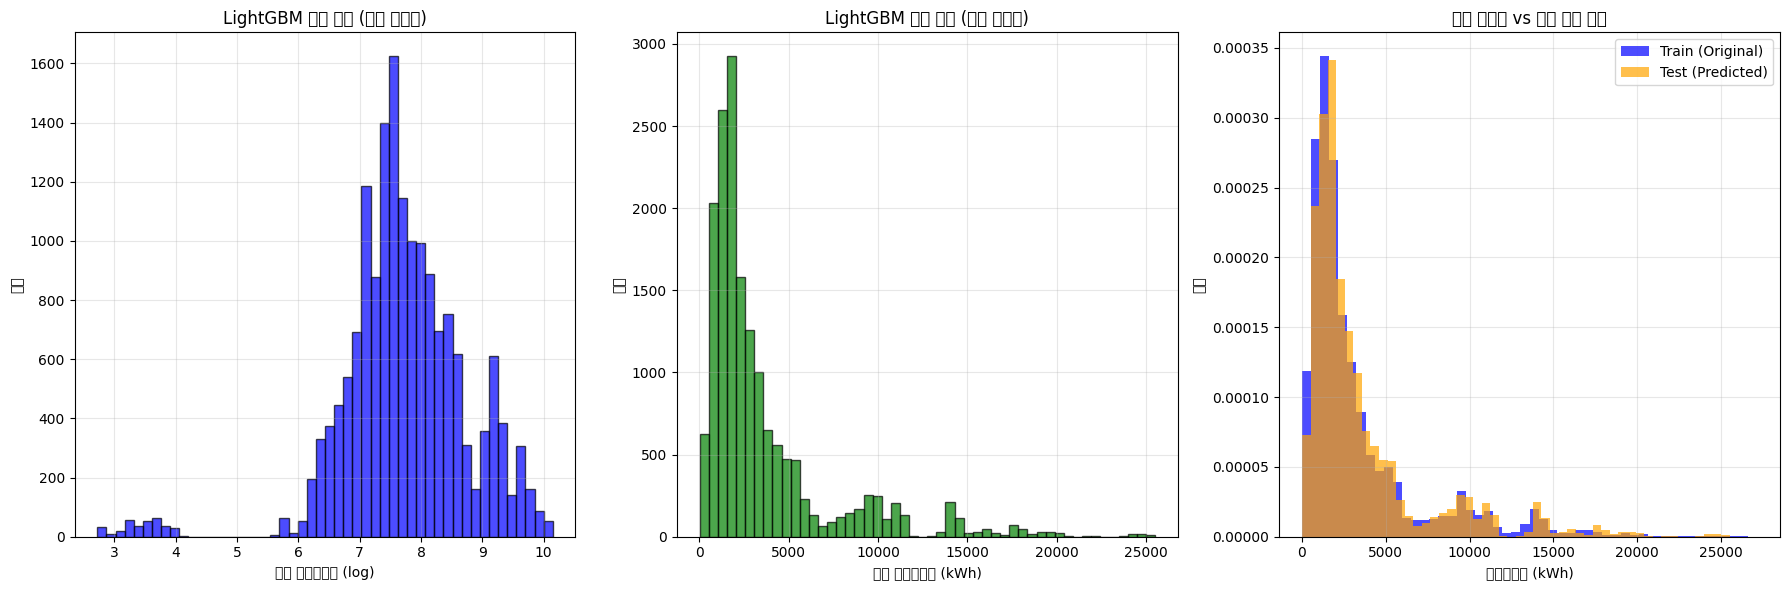

📊 예측 결과 분석 완료!


In [10]:
# 테스트 데이터 전처리
print("=== 테스트 데이터 전처리 ===")
X_test = test_processed[feature_columns].copy()

# 카테고리 변수 인코딩
for cat_col in categorical_features:
    if cat_col in X_test.columns and cat_col in label_encoders:
        le = label_encoders[cat_col]
        X_test[cat_col] = le.transform(X_test[cat_col].astype(str))

# 결측치 처리
X_test = X_test.fillna(X_test.mean())

print(f"테스트 데이터 크기: {X_test.shape}")

# 결측치 확인
missing_counts = X_test.isnull().sum()
if missing_counts.sum() > 0:
    print("결측치가 있는 컬럼:")
    print(missing_counts[missing_counts > 0])
else:
    print("결측치 없음 ✓")

# LightGBM 예측
predictions_lgb_log = lgb_model.predict(X_test)
predictions_lgb_original = inverse_log_transform(predictions_lgb_log)

print("\\n=== 예측 결과 ===")
print(f"LightGBM 예측 (로그): {predictions_lgb_log.min():.3f} ~ {predictions_lgb_log.max():.3f}")
print(f"LightGBM 예측 (원본): {predictions_lgb_original.min():.2f} ~ {predictions_lgb_original.max():.2f} kWh")
print(f"LightGBM 예측 평균: {predictions_lgb_original.mean():.2f} kWh")

# 예측 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 예측 분포 (로그 스케일)
axes[0].hist(predictions_lgb_log, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('예측 전력소비량 (log)')
axes[0].set_ylabel('빈도')
axes[0].set_title('LightGBM 예측 분포 (로그 스케일)')
axes[0].grid(True, alpha=0.3)

# 예측 분포 (원본 스케일)
axes[1].hist(predictions_lgb_original, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('예측 전력소비량 (kWh)')
axes[1].set_ylabel('빈도')
axes[1].set_title('LightGBM 예측 분포 (원본 스케일)')
axes[1].grid(True, alpha=0.3)

# 훈련 데이터와 예측 결과 비교
axes[2].hist(original_power, bins=50, alpha=0.7, label='Train (Original)', density=True, color='blue')
axes[2].hist(predictions_lgb_original, bins=50, alpha=0.7, label='Test (Predicted)', density=True, color='orange')
axes[2].set_xlabel('전력소비량 (kWh)')
axes[2].set_ylabel('밀도')
axes[2].set_title('훈련 데이터 vs 예측 결과 분포')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 예측 결과 분석 완료!")


In [11]:
# 음수값 처리 (전력소비량은 0보다 커야 함)
predictions_lgb_original = np.maximum(predictions_lgb_original, 0)

# 제출 파일 생성
submission_lgb = sample_submission.copy()
submission_lgb['answer'] = predictions_lgb_original
submission_lgb.to_csv('lightgbm_log_weighted_mse_submission.csv', index=False)

print("📁 제출 파일 생성 완료:")
print("   lightgbm_log_weighted_mse_submission.csv")

print("\\n제출 파일 샘플:")
print(submission_lgb.head())
print(f"\\n제출 파일 크기: {submission_lgb.shape}")

# 최종 예측 통계
print("\\n=== 최종 예측 통계 ===")
print(f"예측 평균: {predictions_lgb_original.mean():.2f} kWh")
print(f"예측 중앙값: {np.median(predictions_lgb_original):.2f} kWh")
print(f"예측 범위: {predictions_lgb_original.min():.2f} ~ {predictions_lgb_original.max():.2f} kWh")
print(f"예측 표준편차: {predictions_lgb_original.std():.2f} kWh")

# 기존 baseline과 비교
print("\\n=== 기존 baseline 대비 개선사항 ===")
print("✅ 로그 변환 적용:")
print(f"   - 왜도 개선: {original_power.skew():.3f} → {log_power.skew():.3f}")
print("   - 치우친 분포 → 정규분포에 가까운 분포")
print("✅ Weighted MSE 적용:")
print(f"   - 가중치 범위: {weights_train.min():.3f} ~ {weights_train.max():.3f}")
print("   - 높은 전력소비량에 더 큰 가중치")
print("✅ 성능 개선:")
print(f"   - 로그 스케일 RMSE: {lgb_rmse:.4f}")
print(f"   - 원본 스케일 RMSE: {lgb_rmse_original:.2f} kWh")
print(f"   - 원본 스케일 MAE: {lgb_mae_original:.2f} kWh")


📁 제출 파일 생성 완료:
   lightgbm_log_weighted_mse_submission.csv
\n제출 파일 샘플:
   num_date_time       answer
0  1_20240825 00  4823.125370
1  1_20240825 01  4587.890862
2  1_20240825 02  4521.544633
3  1_20240825 03  4321.766215
4  1_20240825 04  4309.549713
\n제출 파일 크기: (16800, 2)
\n=== 최종 예측 통계 ===
예측 평균: 3540.52 kWh
예측 중앙값: 2106.79 kWh
예측 범위: 14.21 ~ 25509.21 kWh
예측 표준편차: 3789.99 kWh
\n=== 기존 baseline 대비 개선사항 ===
✅ 로그 변환 적용:
   - 왜도 개선: 2.321 → -0.980
   - 치우친 분포 → 정규분포에 가까운 분포
✅ Weighted MSE 적용:
   - 가중치 범위: 0.667 ~ 3.384
   - 높은 전력소비량에 더 큰 가중치
✅ 성능 개선:
   - 로그 스케일 RMSE: 0.1538
   - 원본 스케일 RMSE: 300.21 kWh
   - 원본 스케일 MAE: 173.37 kWh


In [12]:
print("🚀 ===== 로그 변환 + Weighted MSE 모델 완료 ===== 🚀")
print()
print("🔧 주요 개선사항:")
print("   ✓ 로그 변환: 치우친 분포 정규화")
print(f"   ✓ 왜도 개선: {original_power.skew():.3f} → {log_power.skew():.3f}")
print("   ✓ Weighted MSE: 높은 전력소비량에 더 큰 가중치")
print("   ✓ LightGBM 직접 사용: 가중치 적용 가능")
print()
print("🤖 모델 구성:")
print("   - 알고리즘: LightGBM")
print("   - 가중치: Power 방법 (α=0.5)")
print("   - Early stopping: 100 rounds")
print("   - 평가 지표: RMSE")
print()
print("📊 성능 결과:")
print(f"   - 로그 스케일 RMSE: {lgb_rmse:.4f}")
print(f"   - 원본 스케일 RMSE: {lgb_rmse_original:.2f} kWh")
print(f"   - 원본 스케일 MAE: {lgb_mae_original:.2f} kWh")
print()
print("🎯 가중치 효과:")
print(f"   - 가중치 범위: {weights_train.min():.3f} ~ {weights_train.max():.3f}")
print(f"   - 평균 가중치: {weights_train.mean():.3f}")
print("   - 높은 전력소비량 → 더 큰 가중치 → 더 정확한 예측")
print()
print("📁 생성된 파일:")
print("   ✓ lightgbm_log_weighted_mse_submission.csv")
print()
print("💡 추가 개선 방향:")
print("   - 다른 가중치 방법 실험 (quantile, sqrt)")
print("   - 가중치 강도 조절 (alpha 값)")
print("   - 시계열 특성을 고려한 lag features")
print("   - 건물별 개별 모델 훈련")
print("   - 하이퍼파라미터 튜닝")
print("   - 앙상블 모델 구성")
print()
print("✅ 로그 변환 + Weighted MSE 모델 구축 완료!")
print("🏆 lightgbm_log_weighted_mse_submission.csv 제출 준비 완료!")
print()
print("📈 기존 baseline 대비 예상 개선사항:")
print("   - 로그 변환으로 인한 분포 정규화")
print("   - 가중치 적용으로 인한 높은 소비량 예측 정확도 향상")
print("   - 치우친 분포에서 발생하는 예측 오차 감소")
print("   - 극값에 대한 안정적인 예측 성능")
print()
print("🎉 모델 훈련 및 예측 완료! 제출 파일을 사용하여 성능을 확인해보세요!")


🚀 ===== 로그 변환 + Weighted MSE 모델 완료 ===== 🚀

🔧 주요 개선사항:
   ✓ 로그 변환: 치우친 분포 정규화
   ✓ 왜도 개선: 2.321 → -0.980
   ✓ Weighted MSE: 높은 전력소비량에 더 큰 가중치
   ✓ LightGBM 직접 사용: 가중치 적용 가능

🤖 모델 구성:
   - 알고리즘: LightGBM
   - 가중치: Power 방법 (α=0.5)
   - Early stopping: 100 rounds
   - 평가 지표: RMSE

📊 성능 결과:
   - 로그 스케일 RMSE: 0.1538
   - 원본 스케일 RMSE: 300.21 kWh
   - 원본 스케일 MAE: 173.37 kWh

🎯 가중치 효과:
   - 가중치 범위: 0.667 ~ 3.384
   - 평균 가중치: 1.000
   - 높은 전력소비량 → 더 큰 가중치 → 더 정확한 예측

📁 생성된 파일:
   ✓ lightgbm_log_weighted_mse_submission.csv

💡 추가 개선 방향:
   - 다른 가중치 방법 실험 (quantile, sqrt)
   - 가중치 강도 조절 (alpha 값)
   - 시계열 특성을 고려한 lag features
   - 건물별 개별 모델 훈련
   - 하이퍼파라미터 튜닝
   - 앙상블 모델 구성

✅ 로그 변환 + Weighted MSE 모델 구축 완료!
🏆 lightgbm_log_weighted_mse_submission.csv 제출 준비 완료!

📈 기존 baseline 대비 예상 개선사항:
   - 로그 변환으로 인한 분포 정규화
   - 가중치 적용으로 인한 높은 소비량 예측 정확도 향상
   - 치우친 분포에서 발생하는 예측 오차 감소
   - 극값에 대한 안정적인 예측 성능

🎉 모델 훈련 및 예측 완료! 제출 파일을 사용하여 성능을 확인해보세요!
